Dataset loaded successfully!
                                  title  \
0               Foreign Democrat final.   
1   To offer down resource great point.   
2          Himself church myself carry.   
3                  You unit its should.   
4  Billion believe employee summer how.   

                                                text        date    source  \
0  more tax development both store agreement lawy...  2023-03-10  NY Times   
1  probably guess western behind likely next inve...  2022-05-25  Fox News   
2  them identify forward present success risk sev...  2022-09-01       CNN   
3  phone which item yard Republican safe where po...  2023-02-07   Reuters   
4  wonder myself fact difficult course forget exa...  2023-04-03       CNN   

                 author    category label  
0          Paula George    Politics  real  
1           Joseph Hill    Politics  fake  
2        Julia Robinson    Business  fake  
3  Mr. David Foster DDS     Science  fake  
4         Austin Walker

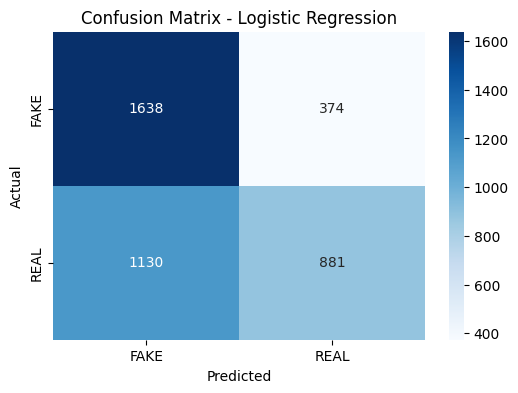

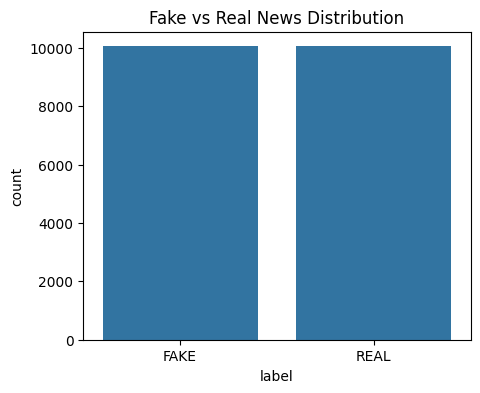

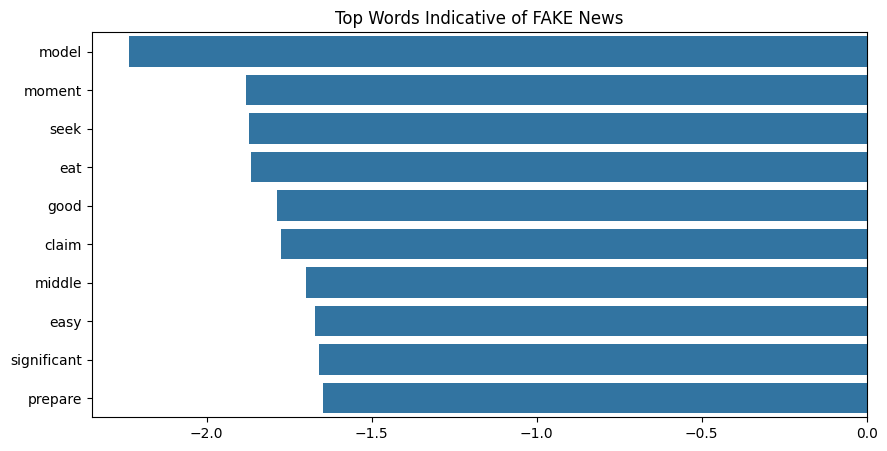

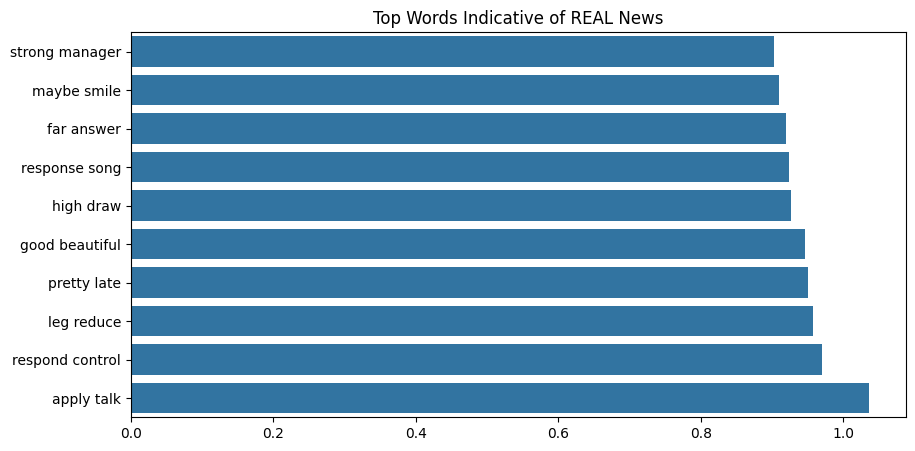

In [3]:
# ===============================
# Fake News Detection using NLP & TF-IDF
# ===============================

import pandas as pd
import numpy as np
import re, string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Load Dataset
# -------------------------------
df = pd.read_csv("news.csv")
print("Dataset loaded successfully!")
print(df.head())

# Drop missing values
df = df.dropna(subset=['text', 'label'])
df = df[df['text'].str.strip() != '']

# Map labels to numbers
df['label'] = df['label'].str.lower().map({'fake': 0, 'real': 1})

# Balance the dataset
df_fake = df[df['label'] == 0]
df_real = df[df['label'] == 1]

df_real_upsampled = resample(df_real,
                             replace=True,
                             n_samples=len(df_fake),
                             random_state=42)

df_balanced = pd.concat([df_fake, df_real_upsampled]).sample(frac=1, random_state=42)
print(f"Balanced dataset: {df_balanced['label'].value_counts()}")

# -------------------------------
# 2. Text Cleaning Function
# -------------------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df_balanced['text'] = df_balanced['text'].apply(clean_text)

# -------------------------------
# 3. Split Data
# -------------------------------
X = df_balanced['text']
y = df_balanced['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 4. TF-IDF Vectorization
# -------------------------------
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1,2), max_features=8000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# -------------------------------
# 5. Train Model (Random Forest or Logistic Regression)
# -------------------------------
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_tfidf, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# -------------------------------
# 6. Evaluate Models
# -------------------------------
for model_name, model in [("Logistic Regression", lr_model), ("Random Forest", rf_model)]:
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {acc*100:.2f}%")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# -------------------------------
# 7. Save Models & Vectorizer
# -------------------------------
joblib.dump(lr_model, "fake_news_lr_model.pkl")
joblib.dump(rf_model, "fake_news_rf_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Models and TF-IDF vectorizer saved successfully!")

# -------------------------------
# 8. Prediction Function
# -------------------------------
def predict_news(text, model=lr_model):
    text_cleaned = clean_text(text)
    vect = tfidf.transform([text_cleaned])
    pred = model.predict(vect)[0]
    return "REAL" if pred == 1 else "FAKE"

# -------------------------------
# 9. Example Prediction
# -------------------------------
sample_news = """
Breaking: Scientists confirm that drinking 20 liters of coffee per day can cure all diseases instantly.
"""
print("\nSample Prediction:", predict_news(sample_news))

# -------------------------------
# 10. Visualization
# -------------------------------
# Confusion Matrix
cm = confusion_matrix(y_test, lr_model.predict(X_test_tfidf))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Label Distribution
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df_balanced)
plt.xticks([0,1], ['FAKE','REAL'])
plt.title("Fake vs Real News Distribution")
plt.show()

# Top Words Indicative of FAKE/REAL
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]
top_fake = np.argsort(coefficients)[:10]
top_real = np.argsort(coefficients)[-10:]

plt.figure(figsize=(10,5))
sns.barplot(x=coefficients[top_fake], y=feature_names[top_fake])
plt.title("Top Words Indicative of FAKE News")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=coefficients[top_real], y=feature_names[top_real])
plt.title("Top Words Indicative of REAL News")
plt.show()
